In [1]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean , get_MOI, get_MOI_2D, get_SHM_invariance_2D
from invariance_functions import degree_of_freedom, get_GPR_model_2D, get_SHM_data_2D, get_double_pendulum_data, evaluate_model_future_2D, evaluate_model_grid_2D, SHM_dynamics1_2D, SHM_dynamics2_2D, get_GPR_model_GD_2D
from local_invariance_kernels import  get_polynomial_local_invariance_2D, get_SHM_local_invariance_2D, get_double_pendulum_local_invariance
from parameterised_invariance_kernels import get_polynomial_invariance_2D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [52]:

mean = ZeroMean(4) 

time_step = 0.01
training_time = 0.1
testing_time = 1

max_x = 3
max_v = 0.3
n_train = 6
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_v, max_v, (n_train))
train_starting_velocity2 = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

data2 = get_SHM_data_2D(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch


[ 1.15353522  2.0646095  -0.23116255 -0.87849055 -1.29827737 -0.50542062]
[ 1.21605273  0.40795151  1.28664167 -2.95929123 -1.84907571 -0.86859343]
[-0.07896949  0.02068797 -0.2737214   0.0648215   0.2184323  -0.02075612]
[ 0.1325508  -0.02532018  0.29957424 -0.10509939 -0.09662776 -0.26572537]


In [57]:

#scalerX = StandardScaler(with_mean=False, with_std=False).fit(data2[0])
#scalerY = StandardScaler(with_mean=False, with_std=False).fit(data2[1])
scalerX = MinMaxScaler((-1,1)).fit(data2[0])
scalerY = MinMaxScaler((-1,1)).fit(data2[1])
X = scalerX.transform(data2[0])
Y = scalerY.transform(data2[1])
data = (X, Y)
scalers = (scalerX, scalerY)
time_setting = (testing_time, time_step)
dynamics = (SHM_dynamics1_2D, SHM_dynamics2_2D)
jitter = 5e-4

#joblib.dump(scalerX, 'shm_2d/scalerX.gz')
#joblib.dump(scalerY, 'shm_2d/scalerY.gz')

In [58]:

print("moi")
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
print(moi.log_marginal_likelihood().numpy())
#try:
n_neighbours =  80
print("known")
kernel_known = get_SHM_local_invariance_2D(0, 2, n_neighbours, jitter) #switch
#kernel_known = get_SHM_invariance_2D(1, n_neighbours, jitter) #switch
known = get_GPR_model_2D(kernel_known, mean, data, iterations=1000)
print(known.log_marginal_likelihood().numpy())

polynomial_degree = 1
print("learnt")
#    X, Y = data
kernel = get_polynomial_local_invariance_2D(0, 2, n_neighbours, jitter, polynomial_degree) 
#kernel = get_polynomial_invariance_2D(1, n_neighbours, jitter, polynomial_degree) 
model = get_GPR_model_2D(kernel, mean, data, iterations=1000, old_model=known)
print(model.log_marginal_likelihood().numpy())
#    model = get_GPR_model_2D(kernel, mean, data, iterations=10000, old_kernel=kernel_known)
#    ckpt = tf.train.Checkpoint(model=model)
#    manager = tf.train.CheckpointManager(ckpt, "shm_2d", max_to_keep=3)
#    model = get_GPR_model_GD_2D(model=model, iterations=10000, lr=0.001, manager=manager)
#    print(model.log_marginal_likelihood().numpy())
#except tf.errors.InvalidArgumentError:
#    print("jitter too small")

moi
872.1589935579935
known
958.8482488416839
learnt
955.8725114356397


In [60]:

eva_future_moi = []
eva_future_known = []
eva_future_learnt = []

def energy(X):
    return 0.5*(tf.square(X[:,0])+tf.square(X[:,1])+tf.square(X[:,2])+tf.square(X[:,3]))
for i in range(5):
    print(i)
    test_starting_position1 = np.random.uniform(-max_x, max_x)
    test_starting_position2 = np.random.uniform(-max_x, max_x)
    test_starting_velocity1 = np.random.uniform(-max_v, max_v)
    test_starting_velocity2 = np.random.uniform(-max_v, max_v)
    test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)
    print(test_starting)
    evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])
    evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_known.append(evaluate_known[0])
    print(evaluate_known[0])
    evaluate_learnt = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_learnt.append(evaluate_learnt[0])
    print(evaluate_learnt[0])

0
(0.6610922208625372, 0.548664209777149, 0.24757345918827162, -0.2022631105465806)
0.0012365785478550188


: 

: 

In [48]:

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
lml_inv_p = model.log_marginal_likelihood().numpy()
print("Log Marginal Likelihood & " + format((lml_moi),".2f")+" & "+ format((lml_inv),".2f") + " & "+ format((lml_inv_p),".2f") + " & "+' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_known),".4f")+" & "+format((np.mean(eva_future_learnt)),".4f")+ ' \\\\')

Log Marginal Likelihood & 845.59 & 949.98 & 944.04 &  \\
MSE & 0.1325 & 0.0186 & 0.0209 \\


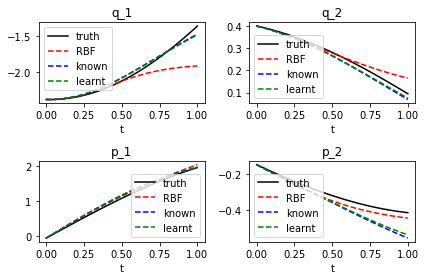

In [51]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))
fig, axs = plt.subplots(2,2)
axs[0][0].plot(t,evaluate_known[4][:,0],label="truth", color="black")
axs[0][0].plot(t,evaluate_moi[1][:,0], "--", label="RBF", color="red")
axs[0][0].plot(t,evaluate_known[1][:,0], "--", label="known", color="blue")
axs[0][0].plot(t,evaluate_learnt[1][:,0], "--", label="learnt", color="green")
axs[0][0].set_title("q_1")
axs[0][0].set_xlabel("t")
axs[0][0].legend()

axs[0][1].plot(t,evaluate_known[4][:,1],label="truth", color="black")
axs[0][1].plot(t,evaluate_moi[1][:,1], "--", label="RBF", color="red")
axs[0][1].plot(t,evaluate_known[1][:,1], "--", label="known", color="blue")
axs[0][1].plot(t,evaluate_learnt[1][:,1], "--", label="learnt", color="green")
axs[0][1].set_title("q_2")
axs[1][1].set_xlabel("t")
axs[0][1].legend()

axs[1][0].plot(t,evaluate_known[4][:,2],label="truth", color="black")
axs[1][0].plot(t,evaluate_moi[1][:,2], "--", label="RBF", color="red")
axs[1][0].plot(t,evaluate_known[1][:,2], "--", label="known", color="blue")
axs[1][0].plot(t,evaluate_learnt[1][:,2], "--", label="learnt", color="green")
axs[1][0].set_title("p_1")
axs[1][0].set_xlabel("t")
axs[1][0].legend()

axs[1][1].plot(t,evaluate_known[4][:,3],label="truth", color="black")
axs[1][1].plot(t,evaluate_moi[1][:,3], "--", label="RBF", color="red")
axs[1][1].plot(t,evaluate_known[1][:,3], "--", label="known", color="blue")
axs[1][1].plot(t,evaluate_learnt[1][:,3], "--", label="learnt", color="green")
axs[1][1].set_title("p_2")
axs[0][1].set_xlabel("t")
axs[1][1].legend()

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.tight_layout()
#plt.savefig("figures/shm_2d_predicted.pdf")


Text(0, 0.5, 'E')

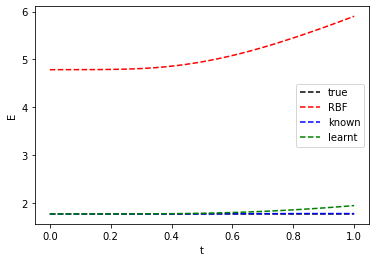

In [30]:

plt.plot(t, evaluate_learnt[5], "--",label="true", color="black")
plt.plot(t, evaluate_moi[6], "--",label="RBF", color="red")
plt.plot(t, evaluate_known[6], "--",label="known", color="blue")
plt.plot(t, evaluate_learnt[6], "--",label="learnt", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
#plt.savefig("figures/shm_2d_energy.pdf")

In [29]:
n_neighbours = 10
print("known")
kernel_known = get_SHM_local_invariance_2D(0.1, 0.5, n_neighbours, jitter) #switch
known = get_GPR_model_2D(kernel_known, mean, data, iterations=1000)
print(known.log_marginal_likelihood().numpy())


kernel = get_polynomial_local_invariance_2D(0.1, 0.5, n_neighbours, jitter, polynomial_degree) 
set_trainable(kernel.poly, False) 
model = get_GPR_model_2D(kernel, mean, data, iterations=1000, old_model=known)
print(model.log_marginal_likelihood().numpy())


polynomial_degree = 1
print("learnt")
test_starting_position1 = np.random.uniform(-max_x, max_x)
test_starting_position2 = np.random.uniform(-max_x, max_x)
test_starting_velocity1 = np.random.uniform(-max_v, max_v)
test_starting_velocity2 = np.random.uniform(-max_v, max_v)
test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)

evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_known[0])
evaluate_learnt = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_learnt[0])

def energy(X):
    return 0.5*(tf.square(X[:,0])+tf.square(X[:,1])+tf.square(X[:,2])+tf.square(X[:,3]))

grids_lml = []
grids_eva = []
for i in range(50):
    print(i)
    kernel_grid = get_polynomial_local_invariance_2D(0.1, 0.5, n_neighbours, jitter, polynomial_degree) 
    kernel_grid.poly = gpflow.Parameter(np.random.normal(size=kernel_grid.poly.shape), trainable=False)
    model_grid = get_GPR_model_2D(kernel_grid, mean, data, iterations=1000, old_model=known)
    print(model_grid.log_marginal_likelihood().numpy())

    evaluate_learnt_grid = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
    grids_eva.append(evaluate_learnt_grid[0])
    grids_lml.append(model.log_marginal_likelihood().numpy())

kernel_free = get_polynomial_local_invariance_2D(0.1, 0.5, n_neighbours, jitter, polynomial_degree) 
model_free = get_GPR_model_2D(kernel_free, mean, data, iterations=1000, old_model=known)
evaluate_learnt_free = evaluate_model_future_2D(model_free, test_starting, dynamics, time_setting, scalers, energy)

known
770.3419761303675
748.3654794502906
learnt
0.0019542761663017636
0.003050065434988409
551.1852972545985
480.03983684131094


KeyboardInterrupt: 